# Calculate SLR regression metrics

#  Load libraries and cleaned data 

In [2]:
import math
import csv
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from sklearn.metrics import r2_score

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

%matplotlib inline

#### Read data

In [3]:
train = pd.read_csv("../data/Ames_cleaning.csv", index_col='Id')
test = pd.read_csv("../data/AmesTest_cleaning.csv", index_col='Id')

In [4]:
train.shape

(2049, 78)

In [5]:
test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,...,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType
Id,,,,,,,,,,,,,,,,,,,,,
2658,190,RM,69.000000,9142,Pave,Grvl,Reg,Lvl,Inside,Gtl,...,0,0,0,None,None,None,0,4,2006,WD
2718,90,RL,69.630042,9662,Pave,None,IR1,Lvl,Inside,Gtl,...,0,0,0,None,None,None,0,8,2006,WD
2414,60,RL,58.000000,17104,Pave,None,IR1,Lvl,Inside,Gtl,...,0,0,0,None,None,None,0,9,2006,New
1989,30,RM,60.000000,8520,Pave,None,Reg,Lvl,Inside,Gtl,...,0,0,0,None,None,None,0,7,2007,WD
625,20,RL,69.630042,9500,Pave,None,IR1,Lvl,Inside,Gtl,...,0,185,0,None,None,None,0,7,2009,WD


### Restore data-type assignments

In [6]:
train['MasVnrArea'] = train['MasVnrArea'].astype(int)
test['MasVnrArea'] = test['MasVnrArea'].astype(int)
train['GarageYrBlt'] = train['GarageYrBlt'].astype(int)
test['GarageYrBlt'] = test['GarageYrBlt'].astype(int)
train['MSSubClass'] = train['MSSubClass'].astype(object)
test['MSSubClass'] = test['MSSubClass'].astype(object)
# train['OverallQual'] = train['OverallQual'].astype(object)
# test['OverallQual'] = test['OverallQual'].astype(object)
# train['YearBuilt'] = train['YearBuilt'].astype(object)
# test['YearBuilt'] = test['YearBuilt'].astype(object)
# train['YearRemodAdd'] = train['YearRemodAdd'].astype(object)
# test['YearRemodAdd'] = test['YearRemodAdd'].astype(object)
# train['OverallCond'] = train['OverallCond'].astype(object)
# test['OverallCond'] = test['OverallCond'].astype(object)
# train['BsmtFullBath'] = train['BsmtFullBath'].astype(object)
# test['BsmtFullBath'] = test['BsmtFullBath'].astype(object)
# train['BsmtHalfBath'] = train['BsmtHalfBath'].astype(object)
# test['BsmtHalfBath'] = test['BsmtHalfBath'].astype(object)
# train['FullBath'] = train['FullBath'].astype(object)
# test['FullBath'] = test['FullBath'].astype(object)
# train['HalfBath'] = train['HalfBath'].astype(object)
# test['HalfBath'] = test['HalfBath'].astype(object)
# train['BedroomAbvGr'] = train['BedroomAbvGr'].astype(object)
# test['BedroomAbvGr'] = test['BedroomAbvGr'].astype(object)
# train['KitchenAbvGr'] = train['KitchenAbvGr'].astype(object)
# test['KitchenAbvGr'] = test['KitchenAbvGr'].astype(object)
# train['TotRmsAbvGrd'] = train['TotRmsAbvGrd'].astype(object)
# test['TotRmsAbvGrd'] = test['TotRmsAbvGrd'].astype(object)
# train['Fireplaces'] = train['Fireplaces'].astype(object)
# test['Fireplaces'] = test['Fireplaces'].astype(object)
# train['GarageCars'] = train['GarageCars'].astype(object)
# test['GarageCars'] = test['GarageCars'].astype(object)
train['MoSold'] = train['MoSold'].astype(object)
test['MoSold'] = test['MoSold'].astype(object)
# train['YrSold'] = train['YrSold'].astype(object)
# test['YrSold'] = test['YrSold'].astype(object)

In [7]:
train.select_dtypes(exclude = object).columns

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemod/Add', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'YrSold', 'SalePrice'],
      dtype='object')

In [8]:
test.select_dtypes(exclude = object).columns

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemod/Add', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'YrSold'],
      dtype='object')

# Merging Numeric/Categorical Features for both Train and 'Kaggle'

In [9]:
train_dummied = pd.get_dummies(train)
test_dummied = pd.get_dummies(test)

In [10]:
train_dummied.shape, test_dummied.shape

((2049, 325), (879, 309))

In [11]:
to_add = set(train_dummied.columns).difference(test_dummied.columns)

In [12]:
for col in to_add:
    test_dummied[col] = 0

In [13]:
train_dummied.shape, test_dummied.shape

((2049, 325), (879, 335))

In [14]:
test_dummied = test_dummied[train_dummied.columns]

In [15]:
train_dummied.shape, test_dummied.shape

((2049, 325), (879, 325))

In [16]:
test_dummied.drop(['SalePrice'], axis = 1, inplace=True)

In [17]:
train_dummied.shape, test_dummied.shape       #  For X, y, "Kaggle"

((2049, 325), (879, 324))

In [18]:
features = [col for col in train_dummied if col != 'SalePrice']
X = train_dummied[features]
y = train_dummied.SalePrice

# Cross-validation, by Train/test/split.

In [19]:
X_train_dummied, X_test_dummied, y_train, y_test = train_test_split(X,y, random_state = 42)

In [20]:
X_train_dummied.shape

(1536, 324)

In [21]:
y_train.shape

(1536,)

#### Validating our training dataset for consistency

In [22]:
lr = LinearRegression()

In [23]:
scores = cross_val_score(lr, X_train_dummied, y_train, cv=5)
scores

array([0.90834654, 0.91097966, 0.88856964, 0.88982249, 0.89804726])

In [24]:
scores.mean()

0.8991531159816339

#### Baseline model is our Mean, \$ 181,486.20

In [25]:
y_train.mean()

181486.20182291666

# Quick Linear-regression Model

In [26]:
lr.fit(X_train_dummied, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [27]:
lr.score(X_train_dummied, y_train)

0.9441861840254592

In [28]:
lr.score(X_test_dummied, y_test)

0.9298971957498748

#### Evidence by modeling for the consistency of our training dataset (even distribution of outliers).

In [29]:
model = lr.fit(X_train_dummied,y_train)

In [30]:
len([model.coef_])

1

In [31]:
model.intercept_

-699422.6767659803

#### Evidence of extreme overfit, which is expected at this preprocessing stage.

In [32]:
len(list(X.columns))

324

In [33]:
betas = pd.DataFrame([model.coef_], columns=list(X.columns)).T

In [34]:
betas.columns = ['weights']

In [35]:
betas['abs_w'] = betas.weights.abs()

In [36]:
beta_0 = model.intercept_

In [37]:
weights = betas.sort_values('abs_w', ascending=False)['weights'].head(8)

In [38]:
labels = weights.index

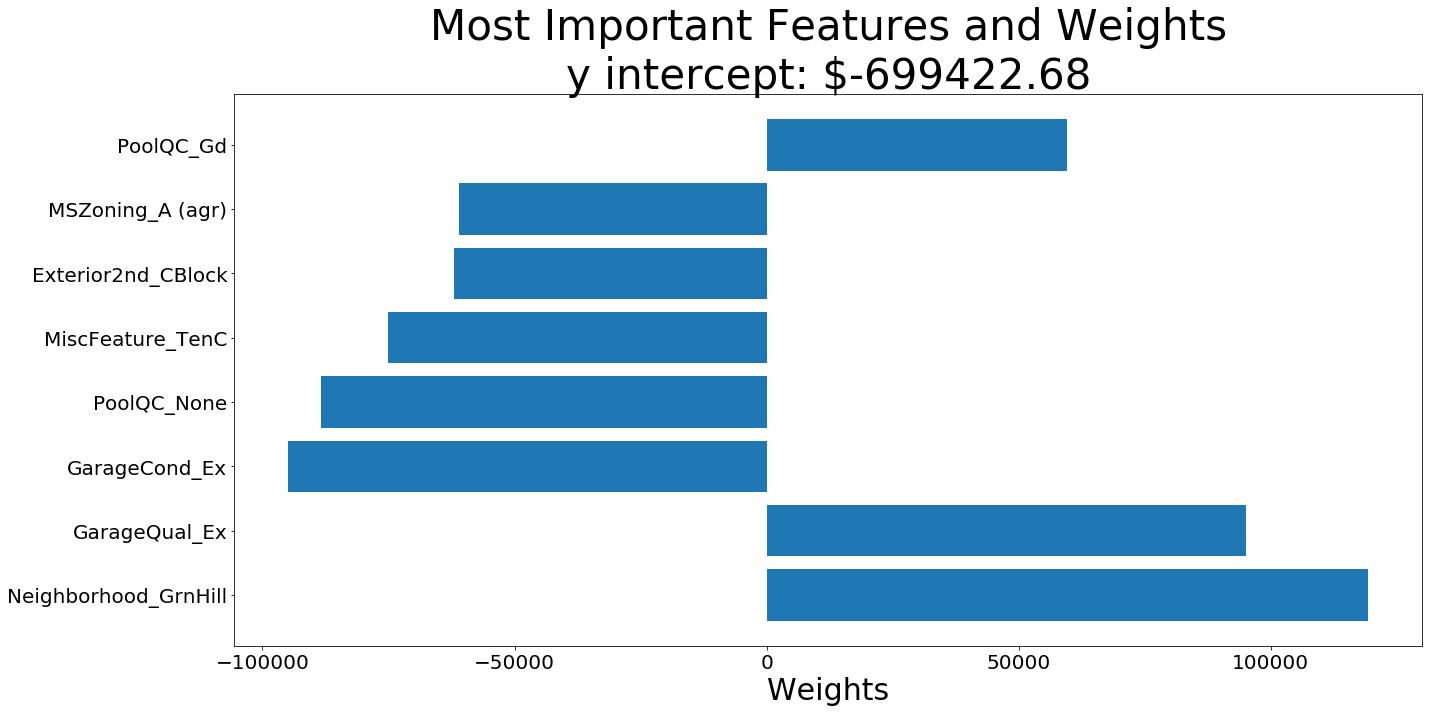

In [39]:
plt.figure(figsize=(20,10))
plt.barh(labels, weights)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Weights', fontsize=30)
plt.title(f'Most Important Features and Weights\ny intercept: ${beta_0:0.02f}', fontsize=42)
plt.tight_layout()

### Fitting a line for quick visualizations.

In [40]:
predictions = model.predict(X_test_dummied)

In [41]:
predictions.min()

33865.333841819665

In [42]:
y_test.min()

12789

In [43]:
score = model.score(X_test_dummied,y_test)

In [44]:
np.max(y)

611657

Text(0.5,1,'Ames Home-Price L-R Model')

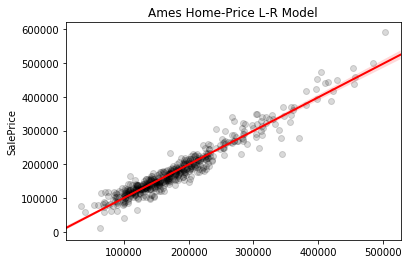

In [45]:
sns.regplot(predictions,y_test,
            scatter_kws={'alpha':0.15,"color":'k'},
            line_kws={'color':'r','linewidth':2}).set_title("Ames Home-Price L-R Model")

In [46]:
pred_df = pd.DataFrame(predictions, index=y_test.index)

#### Another plot of the same results.

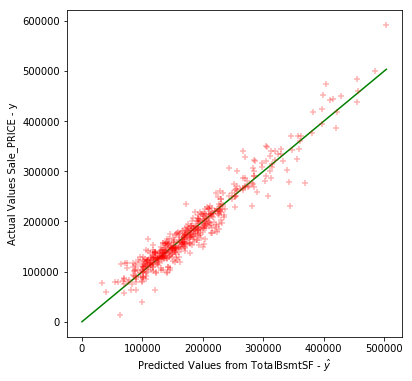

score:  0.9298971957498748


In [49]:
plt.figure(figsize=(6,6))
plt.scatter(predictions, y_test, s=30, c='r', marker='+', zorder=10, alpha=0.3)
plt.xlabel("Predicted Values from TotalBsmtSF - $\hat{y}$")
plt.ylabel("Actual Values Sale_PRICE - y")

# plt.plot([0, np.max(y_test)], [0, np.max(y_test)], c = 'b')
plt.plot([0, np.max(predictions)], [0, np.max(predictions)], c = 'g')


plt.show()

print("score: ", score)

### Scaling for variance.

In [49]:
ss = StandardScaler()

In [50]:
X_train_dum_sc = ss.fit_transform(X_train_dummied)

In [51]:
X_test_dum_sc = ss.transform(X_test_dummied)

# Saving results: Test_dummied (unscaled); Scaler; Columns

In [52]:
with open('../data/X_train_dum_sc.csv', 'w+') as f:
    csv_writer = csv.writer(f)
    csv_writer.writerows(X_train_dum_sc)

In [53]:
with open('../data/X_test_dum_sc.csv', 'w+') as f:
    csv_writer = csv.writer(f)
    csv_writer.writerows(X_test_dum_sc)

In [54]:
train_dummied.to_csv('../data/train_dum.csv')
test_dummied.to_csv('../data/test_dum.csv')

In [55]:
y_train.to_csv('../data/y_train.csv', index=False)
y_test.to_csv('../data/y_test.csv', index=False)

In [56]:
with open('../data/scaler.pkl', 'wb+') as f:
    pickle.dump(ss, f)

In [72]:
with open('../data/lin_reg.pkl', 'wb+') as f:
    pickle.dump(lr, f)

In [58]:
with open('../data/columns.pkl', 'wb+') as f:
    pickle.dump(list(X.columns), f)

# Trial submission

In [59]:
kaggle = ss.transform(test_dummied)

In [60]:
predictors = lr.predict(kaggle)
predictors.shape

(879,)

In [61]:
submission = pd.DataFrame(predictors, index=test_dummied.index, columns=['SalePrice'])

In [62]:
submission.sort_index(inplace=True)

In [63]:
submission.to_csv('../data/submission.csv')

In [64]:
submission.shape

(879, 1)

In [65]:
submission.head()

,SalePrice
Id,
2,-569297.836945
4,-553077.199281
6,-765327.303919
7,-524414.536095
17,-415404.452937





### Some efforts was made in the manual inspection for feature selection based on simple correlations :




# Comparison of the Correlations between Price and Numerical Features is consistent with Model-Scoring above:

In [66]:
data = train.select_dtypes(exclude = object)
def corr_func(df):
    for col in data:
        print(train[[col,'SalePrice']].corr())
corr_func(data)

             LotFrontage  SalePrice
LotFrontage      1.00000    0.33901
SalePrice        0.33901    1.00000
            LotArea  SalePrice
LotArea    1.000000   0.303744
SalePrice  0.303744   1.000000
             OverallQual  SalePrice
OverallQual     1.000000   0.803462
SalePrice       0.803462   1.000000
             OverallCond  SalePrice
OverallCond     1.000000  -0.097093
SalePrice      -0.097093   1.000000
           YearBuilt  SalePrice
YearBuilt   1.000000   0.572405
SalePrice   0.572405   1.000000
               YearRemod/Add  SalePrice
YearRemod/Add       1.000000   0.550872
SalePrice           0.550872   1.000000
            MasVnrArea  SalePrice
MasVnrArea    1.000000   0.511273
SalePrice     0.511273   1.000000
            BsmtFinSF1  SalePrice
BsmtFinSF1    1.000000   0.445576
SalePrice     0.445576   1.000000
            BsmtFinSF2  SalePrice
BsmtFinSF2    1.000000   0.016215
SalePrice     0.016215   1.000000
           BsmtUnfSF  SalePrice
BsmtUnfSF   1.000000   0.1901

In [67]:
# LotFrontage > 0.355
# LotArea     > 0.32
# OverallQual > 0.80 *** 1st-Numeric Predictor
# YearBuilt   > 0.52 *
# YearRemodAdd> 0.51
# MasVnrArea  > 0.47
# BsmtFinSF1  > 0.40
# TotalBsmtSF > 0.63 **  4th-Numeric Predictor
# 1stFlrSF    > 0.62 **
# 2ndFlrSF    > 0.32
# GrLivArea   > 0.72 *** 2nd-Numeric Predictor
# FullBath    > 0.56 *
# TotRmsAbvGrd> 0.53 *
# GarageCars  > 0.64 **  3rd-Numeric Predictor
# GarageArea. > 0.62 (**)

### Look at the cross-correlations between predictor cadidates from numerical features can suggest feature independence:

In [68]:
train_numpre = train[['OverallQual','GrLivArea','TotalBsmtSF','GarageCars','SalePrice']]
train_numpre.head()

,OverallQual,GrLivArea,TotalBsmtSF,GarageCars,SalePrice
Id,,,,,
109,6,1479,725.0,2.0,130500
544,7,2122,913.0,2.0,220000
153,5,1057,1057.0,1.0,109000
318,5,1444,384.0,2.0,174000
255,6,1445,676.0,2.0,138500


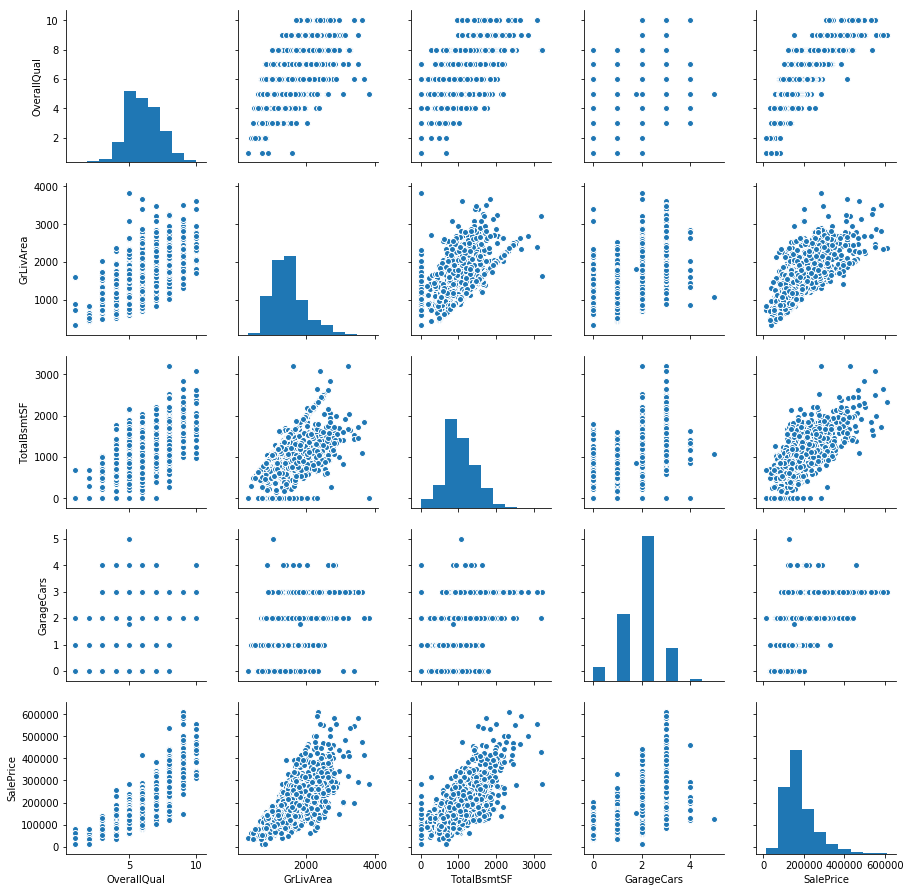

In [69]:
sns.pairplot(train_numpre)

## On preliminary analysis, four numeric predictors to focus on are 'OverallQual', 'GrLivArea' and 'GarageCars'.

## Categorical feature-dummy candidates as predictors:

In [70]:
# MSZoning/RL        
# Street/Pave        
# Alley/None         
# LotShape/IR1       
# LandContour/Lvl    
# LandSlope/Gtl      
# Neighborhood       
# Condition1/Norm   
# Condition1/Norm    
# BldgType/1Fam      
# HouseStyle/2Story 
# RoofStyle/Hip      
# RoofMatl/CompShg   
# MasVnrType/BrkFace 
# ExterQual/Gd       
# ExterCond/TA       
# Foundation/PConc  
# BsmtQual/Ex   
# ...

# Please continue in Notebook-3.